- Time Domain
  - Template of SCG
  - Analytic Signal and Hilbert Transform
  - Peak Detection
    - Peak of Peak Algorithm
  - Envelope Extraction
    - Envelope from Peaks
    - Average Envelope
    - Envelope and Phase Extraction using Hilbert Transform
  - Singular Spectrum Transform (SST)
  - Time Domain Feature
    - Petrosian Fractal Dimension (PFD)
- Frequency Domain
  - Fast Fourier Transform (FFT)
  - Frequency Domain Feature
    - Power Spectral Density (PSD)
    - Skewness and Kurtosis
- Time-Frequency Domain
  - Short Time Fourier Transform (STFT)
  - Wavelet Analysis
    - Mexican Hat Wavelet
    - Morlet Wavelet
    - Continuous Wavelet Transform (CWT)
    - Inverse CWT
  - Polynomial Chirplet Transform (PCT)
    - Chirplet Transform
    - Polynomial Chirplet Transform
  - Wigner Ville Distribution (WVD)
  - SynchroSqueezing Transform (SST)

# Time Domain

## Template of SCG
It is a simple method to get the template of the synthesized scg signal, using cluster and average. The algorithm is as follows:
1. Use the middle of peaks to segment the signal.
2. Add a new segment to the existing clusters, whose middle has the least RMSE distance with the signal. If there is no existing cluster, use the new segment as the middle of a new cluster. If the least RMSE distance is greater than a threshold, create a new cluster too.
3. Continue the former step until all the segments belong to a cluster.
4. Use the average of the cluster which has the most segments as the template.

Note: It is only suitable for the synthesized scg signal and is a simplified version.

Help on function get_template in module dsp:

get_template(signal, threshold=5e-06)
    Description:
        use cluster method to get the template
    Args:
        signal: the periodic signal
    Returns:
        The template of the periodic signal


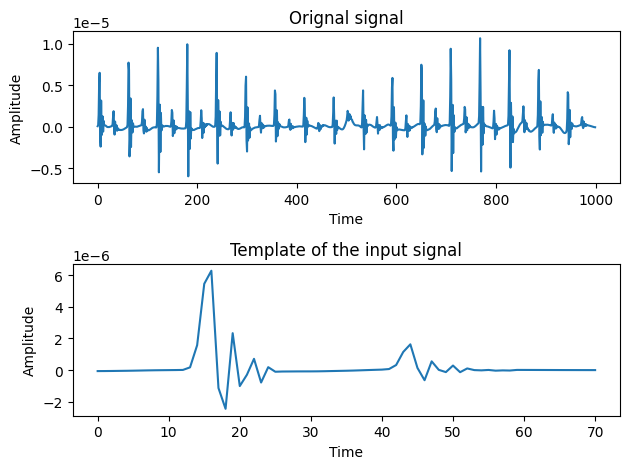

In [48]:
import numpy as np
from matplotlib import pyplot as plt
from dsp import get_template

help(get_template)

signal = np.load("./data/sim_100_0.1_90_140_train.npy")[1,:1000]
template = get_template(signal)

fig, axis = plt.subplots(2,1)
axis[0].set_title("Orignal signal")
axis[0].set_xlabel("Time")
axis[0].set_ylabel("Amplitude")
axis[0].plot(signal)

axis[1].set_title("Template of the input signal")
axis[1].set_xlabel("Time")
axis[1].set_ylabel("Amplitude")
axis[1].plot(template)

plt.tight_layout()
plt.show()

## Analytic Signal and Hilbert Transform

Fourier Transform of a real-valued signal is complex-symmetric whose negative frequencies are redundant with respect to the positive frequencies. To remove the redundancy, the analytic signal is invented. It is complex-valued but its spectrum will be one-sided (only positive frequencies) that preserved the spectral content of the original real-valued signal. Using an analytic signal instead of the original real-valued signal, is useful in many signal processing applications. For example, in spectral analysis, use of analytic signal in-lieu of the original real-valued signal mitigates estimation biases and eliminates cross-term artifacts due to negative and positive frequency components.

In the frequency domain, the analytic signal has only the postive part of the original signal and the magnitude is two times of the orignal postive spectrum. In the time domain, the real part of the analytic signal is the same as the original signal, but it has a imaginary part.
$$
z(t) = z_{r}(t) + z_{i}(t) = x(t) + z_{i}(t)
$$
where $z(t)$ denotes the time domain analytic singal, and $x(t)$ denotes the original signal. The subscripts $i$ and $r$ mean the imaginary and real.

So what's the imaginary part? Hilbert Transformation can be used to find the imaginary part of the orignal real-valude signal.
$$
z(t) = z_{r}(t) + z_{i}(t) = x(t) + jHT\{x(t)\}
$$
$$
HT\{x(t)\} = x(t) * \frac{1}{\pi t} \longleftrightarrow F(f)[-jsgn(f)] = \begin{cases}-jF(f) & f > 0 \\ jF(f) & f< 0 \end{cases}
$$
where $j$ is an imaginary unit, $HT\{\}$ denotes hilbert transform, $F()$ denotes the spectrum of the original signal, * denotes the convolution, $\longleftrightarrow$ denotes the mutual conversion of signals between the time domain and the frequency domain, $sgn()$ denotes the sign function, which returns -1 for negative numbers, 0 for zero, and 1 for positive numbers.

We can take the hilbert transformation as a filter whose impulse response is $\frac{1}{\pi t}$. And the HT\{x(t)\} has some properties.
1. HT\{HT\{x(t)\}\} = -x(t)
2. HT\{x(t)\} has the opposite parity of x(t)
3. HT\{x(t)\} and x(t) are orthogonal

Help on function analytic_signal in module dsp:

analytic_signal(x)
    Description:
        Get the analytic version of the input signal
    Args:
        x: input signal which is a real-valued signal
    Returns:
        The analytic version of the input signal which is a complex-valued signal

Help on function hilbert_transform in module dsp:

hilbert_transform(x)
    Description:
        Get the hilbert transformation of the input signal
    Args:
        x: a real-valued singal
    Returns:
        Return the result of hilbert transformation which is the imaginary part of the analytic signal. It is a
        real-valued number.


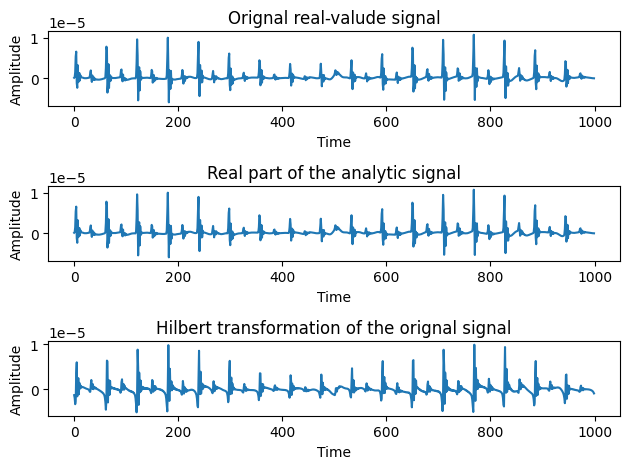

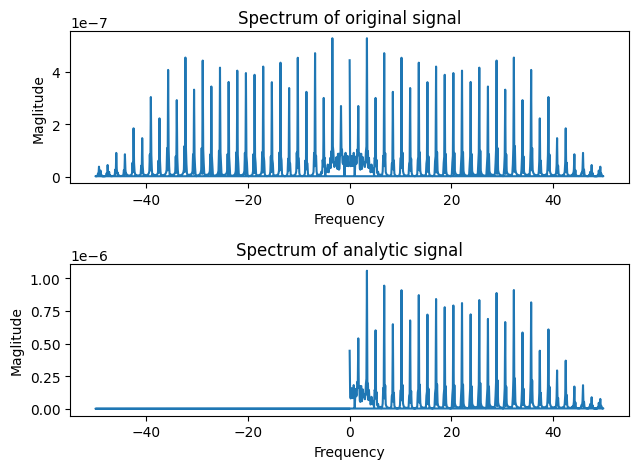

In [49]:
import numpy as np
from matplotlib import pyplot as plt
from dsp import analytic_signal, hilbert_transform, my_fft

help(analytic_signal)
help(hilbert_transform)

signal = np.load("./data/sim_100_0.1_90_140_train.npy")[1,:1000]
z = analytic_signal(signal)

fig, axis = plt.subplots(3,1)
axis[0].set_title("Orignal real-valude signal")
axis[0].set_xlabel("Time")
axis[0].set_ylabel("Amplitude")
axis[0].plot(signal)

axis[1].set_title("Real part of the analytic signal")
axis[1].set_xlabel("Time")
axis[1].set_ylabel("Amplitude")
axis[1].plot(z.real)

axis[2].set_title("Hilbert transformation of the orignal signal")
axis[2].set_xlabel("Time")
axis[2].set_ylabel("Amplitude")
axis[2].plot(hilbert_transform(signal))
plt.tight_layout()
plt.show()

freq_original, mag_original = my_fft(signal, 100)
freq_analytic, mag_analytic = my_fft(z, 100)

fig, axis = plt.subplots(2,1)
axis[0].set_title("Spectrum of original signal")
axis[0].plot(freq_original, np.abs(mag_original))
axis[0].set_xlabel("Frequency")
axis[0].set_ylabel("Magnitude")

axis[1].set_title("Spectrum of analytic signal")
axis[1].plot(freq_analytic, np.abs(mag_analytic))
axis[1].set_xlabel("Frequency")
axis[1].set_ylabel("Magnitude")

plt.tight_layout()
plt.show()

## Peak Detection

### Peak of Peak Algorithm
The algorithm first use scipy.signal.find_peaks to detect all the peaks in a signal and perform linear interpolation to obtain an envelope which still preserve the shape of the original signal and the peak location. After getting the envelope, we use scipy.signal.find_peaks to detect the peaks in the envelope and filter the abnormal value to get the time of all peaks.

Usage Scenario: There are many high frequency noises and the noises don't influence the shape of the original signal.

Help on function get_peaks in module dsp:

get_peaks(signal)
    Description:
        Detect peaks in a signal and perform linear interpolation to obtain an envelope.
    
    Params:
        signal (numpy.ndarray): The input signal.
    
    Returns:
        peaks (numpy.ndarray): An array containing the indices of the detected peaks.


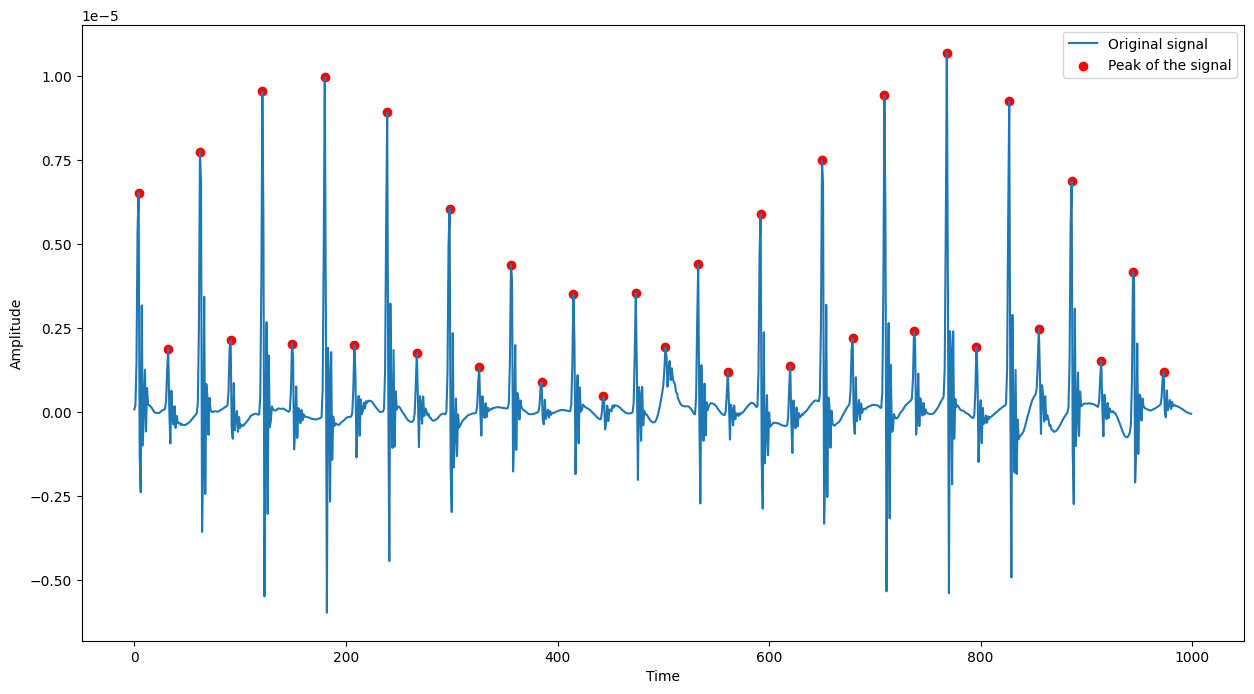

In [56]:
from dsp import get_peaks
import numpy as np
import matplotlib.pyplot as plt

help(get_peaks)

signal = np.load("./data/sim_100_0.1_90_140_train.npy")[1,:1000]
peaks = get_peaks(signal)
plt.figure(figsize=(15,8))
plt.plot(signal, label="Original signal")
plt.scatter(peaks,signal[peaks],c="red", label="Peak of the signal")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

## Envelope Extraction

### Envelope from Peaks
We can use the first step of peak of peak algorithm as a kind of envelope generation algorithm. We can perform linear interpolation of all peaks to obtain an envelope.

Usage Scenario: We only focus on locations of peaks on the envelope.

Help on function envelope_from_peaks in module dsp:

envelope_from_peaks(signal)
    Description
        Interpolation the peaks to get the envelope of the input signal. The algorithm is only suitable for the signal
        with a lot of noise
    Args:
        signal: The input signal
    Returns:
        envelope: The envelope of the input signal


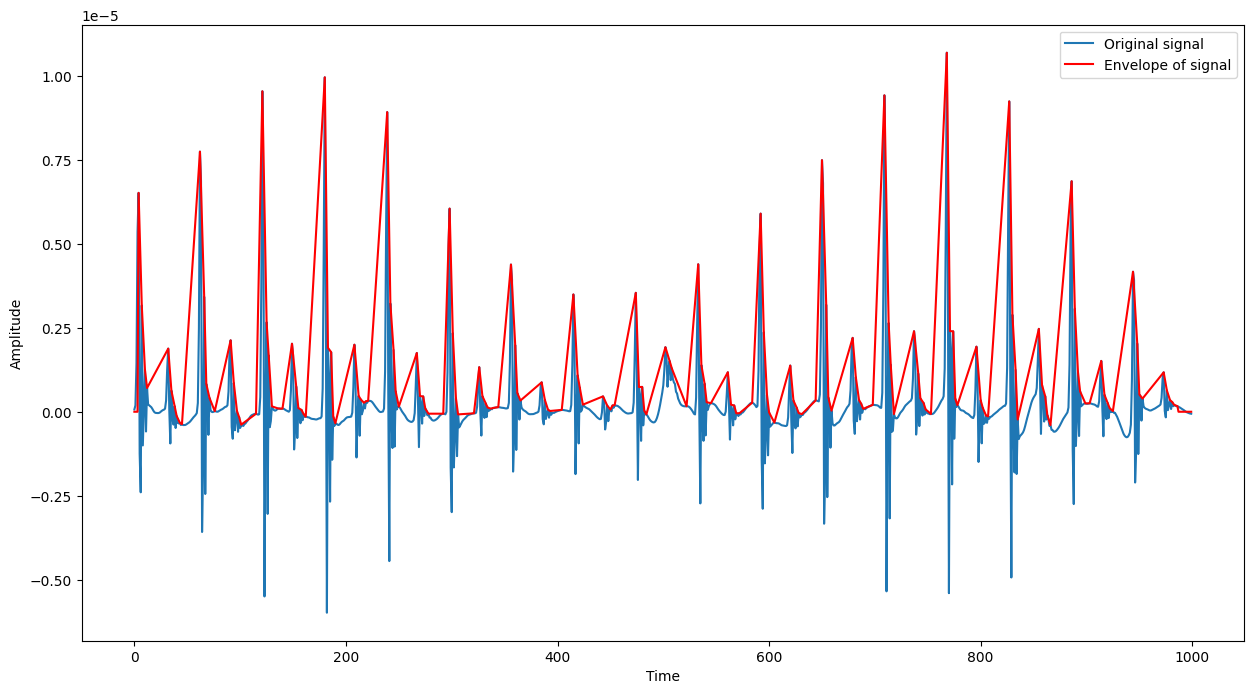

In [58]:
from dsp import envelope_from_peaks
import numpy as np
import matplotlib.pyplot as plt

help(envelope_from_peaks)

signal = np.load("./data/sim_100_0.1_90_140_train.npy")[1,:1000]
envelope = envelope_from_peaks(signal)
plt.figure(figsize=(15,8))
plt.plot(signal,label="Original signal")
plt.plot(envelope,c="red", label="Envelope of signal")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

### Average Envelope
We can also use the average window to get the envelope. The average window will calculate the average value of a region to replace the middle timestamp in the region. The longer the window, the smoother the envelope, but the more serious it will change the shape of the original signal.
$$
    envelope[i]~=~signal[i-\frac{window\_length}{2}]~+~....~+~signal[i]~+~....~+~signal[i+\frac{window\_length}{2}]
$$

Usage Scenario: It is suitable for signals with relatively stable periodicity and slow amplitude variations. This is because the moving average window can eliminate high-frequency noise while preserving the low-frequency characteristics of the signal. However, this envelope will lose the information of peaks' vertical location.

Help on function average_envelope in module dsp:

average_envelope(signal, window_length)
    Description:
        Use the average window to get the envelope
    Args:
        signal: input signal
        window_length: the length of the average window
    Returns:
        envelope: the envelope of the input signal


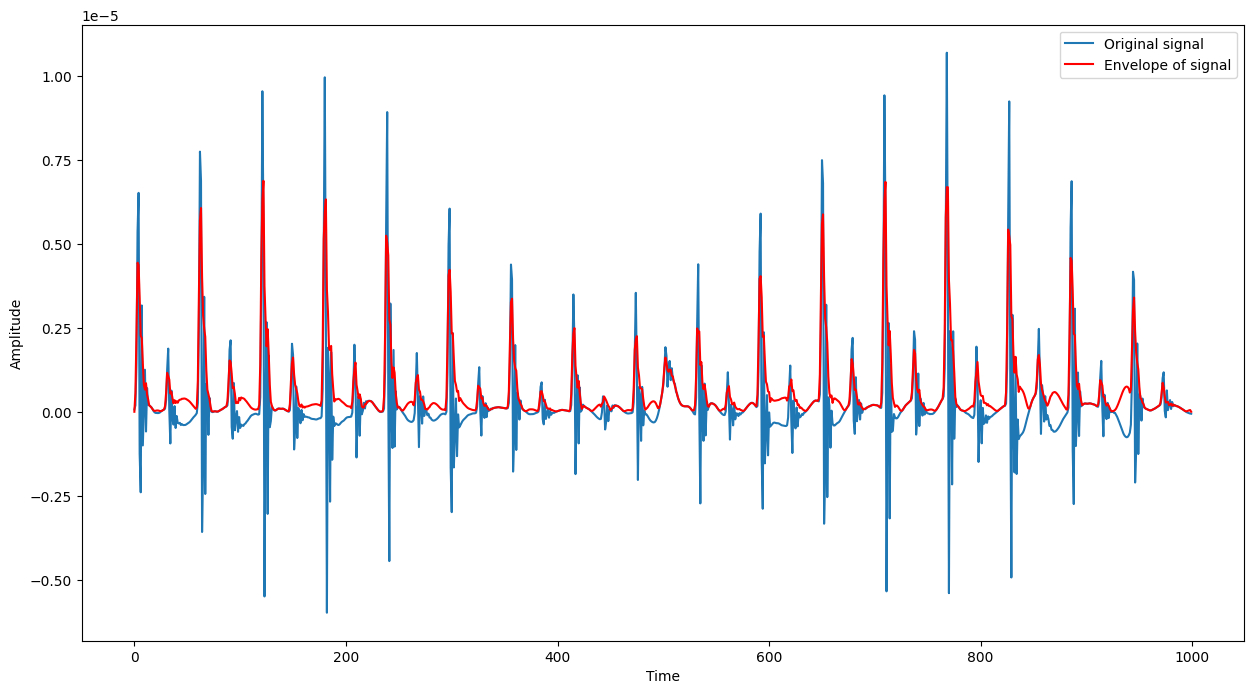

In [59]:
from dsp import average_envelope
import numpy as np
import matplotlib.pyplot as plt

help(average_envelope)

signal = np.load("./data/sim_100_0.1_90_140_train.npy")[1,:1000]
envelope = average_envelope(signal, 3)
plt.figure(figsize=(15,8))
plt.plot(signal,label="Original signal")
plt.plot(envelope,c="red",label="Envelope of signal")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

### Envelope and Phase Extraction using Hilbert Transform

If a modulated signal is expressed as $x(t) = a(t) cos[ \phi (t)]$

The instantaneous amplitude or the envelope of the signal is given by $a(t)$

The instantaneous phase is given by  $\phi(t)$

The instantaneous angular frequency is derived as $\omega(t) = \frac{d}{dt} \phi(t)$

The instantaneous temporal frequency is derived as $f(t) = \frac{1}{2 \pi} \frac{d}{dt} \phi(t)$

We note that the modulated signal is a real-valued signal. We also take note of the fact that amplitude/phase and frequency can be easily computed if the signal is expressed in complex form. So we can use Hilbert transformation to transform the real-valued signal to a complex version.

The analytic signal is 
$$
z(t) = z_{r}(t) + z_{i}(t) = x(t) + jHT\{x(t)\}
$$
So
$$
a(t) = |z(t)| = \sqrt{z_r^2(t) + z_i^2(t)} 
$$
$$
\phi(t) = \angle z(t) = arctan \left[ \frac{z_i(t)}{z_r(t)} \right] 
$$
$$
f(t) = \frac{1}{2 \pi} \frac{d}{dt} \phi(t) 
$$

where $z(t)$ denotes the analytic signal, the subscripts $i$ and $r$ mean the imaginary and real, $j$ is an imaginary unit, and $HT\{\}$ denotes hilbert transform.

Usage Scenario: It is suitable for signals with non-stationary and rapidly varying amplitudes. It is particularly effective for signals with high-frequency components, as it can accurately capture the envelope by estimating the instantaneous amplitude of the signal. 

Help on function inst_amplitude in module dsp:

inst_amplitude(signal)
    Description:
        Use hilbert transformation to compute the instantaneous amplitude or the envelope of the input signal
    Args:
        signal: input signal
    Returns:
        The instantaneous amplitude or the envelope of the signal

Help on function inst_phase in module dsp:

inst_phase(signal)
    Description:
        Use hilbert transformation to compute the instantaneous phase of the input signal
    Args:
        signal: input signal
    Returns:
        instantaneous phase

Help on function inst_freq in module dsp:

inst_freq(signal, fs)
    Description:
        Use hilbert transformation to compute the instantaneous temporal frequency of the input signal
    Args:
        signal: input signal
        fs: frequency of sampling of input signal
    Returns:
        the instantaneous temporal frequency


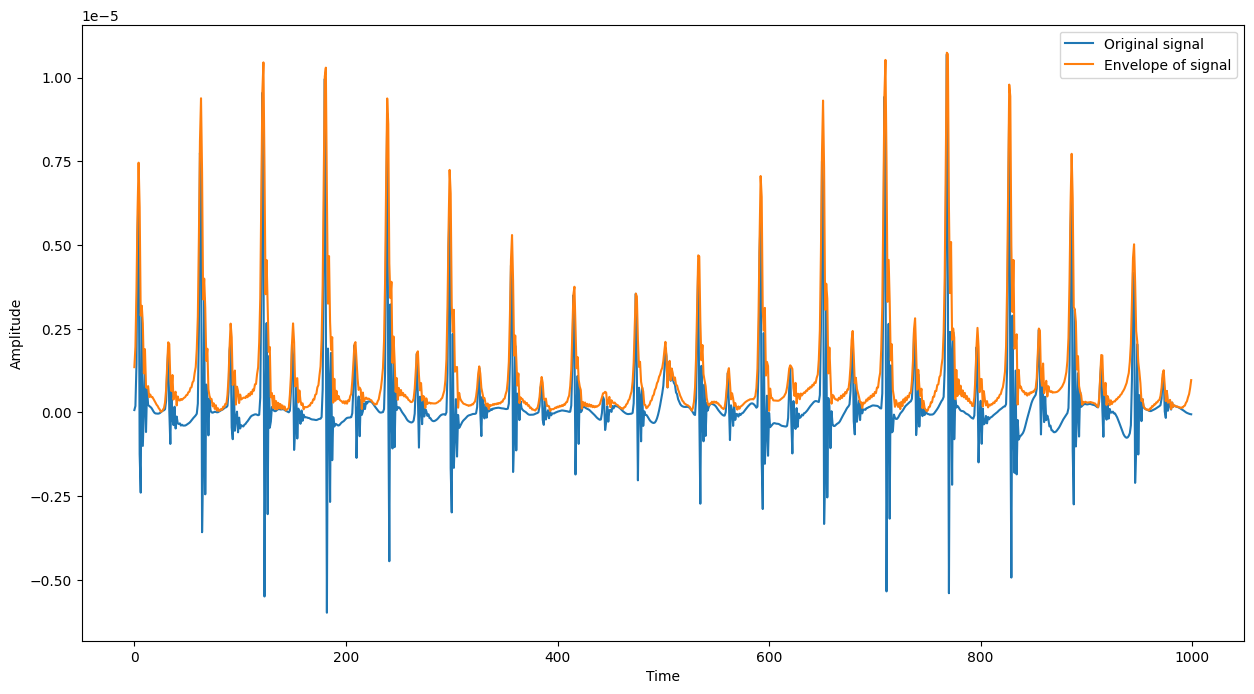

In [60]:
import numpy as np
import matplotlib.pyplot as plt
from dsp import inst_amplitude, inst_phase, inst_freq

help(inst_amplitude)
help(inst_phase)
help(inst_freq)

signal = np.load("./data/sim_100_0.1_90_140_train.npy")[1,:1000]

plt.figure(figsize=(15, 8))
plt.plot(signal,label="Original signal")
plt.plot(inst_amplitude(signal),label="Envelope of signal")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

## Singular Spectrum Transform (SST)

SST is a signal processing technique based on singular spectrum analysis, used for extracting trends and periodic components in a signal. SST is primarily employed for decomposing signals and reconstructing their components to better understand the structure and features of the signal. This technique is usually used for the change point detection. In the example, we can find that where the signal changes a lot has a relative high score.

The main steps of SST include:

1. **Embedding**:
   Convert the original signal into matrix form. This often involves creating a Hankel matrix where rows and columns consist of subsequences of the original signal. This embedding process helps capture local structures in the signal.

2. **Singular Value Decomposition (SVD)**:
   Perform singular value decomposition on the embedded matrix, breaking it down into three matrices: U, Σ, and V^T. Here, U contains the left singular vectors, Σ contains the singular values in a diagonal matrix, and V^T contains the right singular vectors.

3. **Grouping and Reconstruction**:
   Group the singular values based on their magnitudes into several subsequences. These subsequences correspond to different frequency and trend components of the signal. By selecting relevant combinations of singular values, different components of the original signal can be reconstructed.

4. **Back-Transformation**:
   Perform the inverse transformation on the decomposed subsequences to obtain an estimate of the original signal. This step involves reversing the embedding operation on the reconstructed subsequences.

Help on function sst in module dsp:

sst(signal, win_length)
    Description:
        It is a change point detection algorithm
    Args:
        signal: the input signal
        win_length: window length of Hankel matrix
    Returns:
        score: an array measuring the degree of change


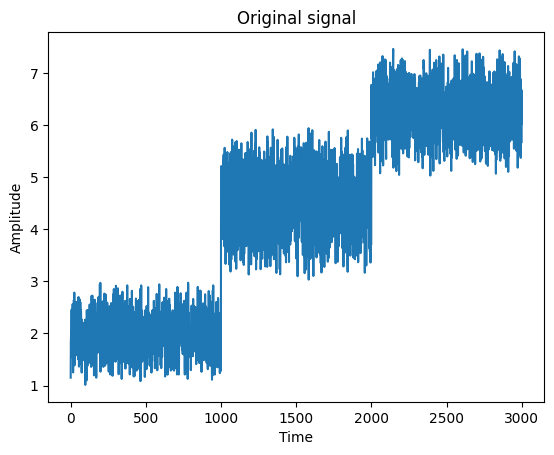

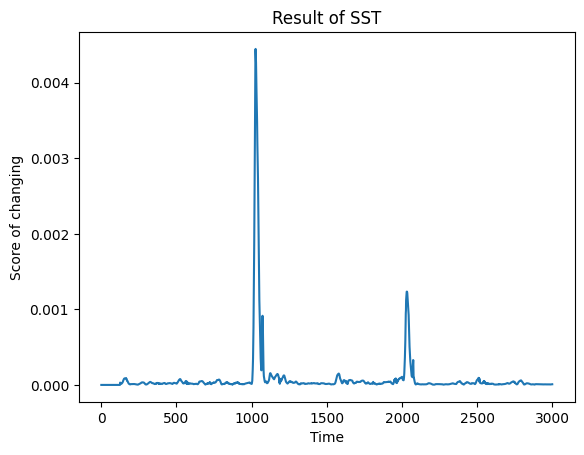

In [61]:
from dsp import sst
import numpy as np
import matplotlib.pyplot as plt

help(sst)

x0 = 1 * np.ones(1000) + np.random.rand(1000) * 1
x1 = 3 * np.ones(1000) + np.random.rand(1000) * 2
x2 = 5 * np.ones(1000) + np.random.rand(1000) * 1.5
signal = np.hstack([x0, x1, x2])
signal +=  np.random.rand(signal.size)

score = sst(signal, win_length=50)

plt.title("Original signal")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.plot(signal)
plt.show()

plt.title("Result of SST")
plt.plot(score)
plt.xlabel("Time")
plt.ylabel("Score of changing")
plt.show()

## Time Domain Feature

### Petrosian Fractal Dimension (PFD)

Petrosian Fractal Dimension (PFD) is a method used to measure the complexity of time-series signals, particularly applicable in biomedical signals such as electrocardiograms (ECG). It calculates the fractal dimension of a signal to describe its complexity and irregularity. A higher Petrosian Fractal Dimension value indicates a more complex signal.
$$
PFD = \frac{\log_{10}(N)}{\log_{10}(N) + \log_{10}\left(\frac{N}{N + 0.4N_{\text{zc}}}\right)}
$$
where $N$ is the length of the signal and $N_{zc}$ is the number of zero crossings in the signal derivative.

The example shows that the signal with noise is more complex than the original signal, so that the noisy signal has a bigger PFD than the orignal signal.

Help on function pfd in module dsp:

pfd(signal)
    Description:
        It calculates the fractal dimension of a signal to describe its complexity and irregularity. A higher Petrosian
        Fractal Dimension value indicates a more complex signal.
    Args:
        signal: The input signal
    Returns:
        The value of pfd


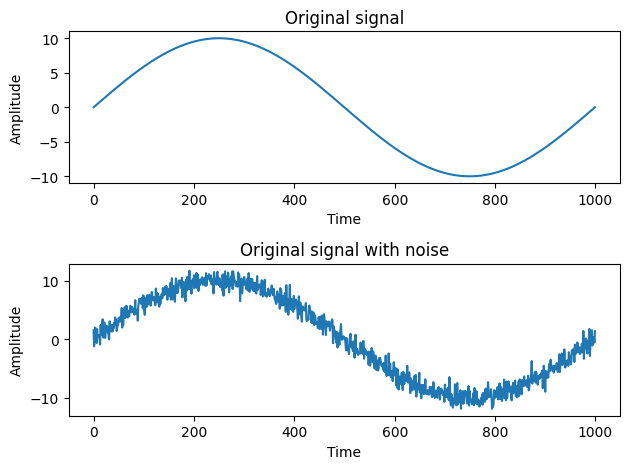

PFD of original signal:  1.0001157789650048
PFD of original signal with noise:  1.0357435311587997


In [7]:
import numpy as np
from dsp import get_template, pfd, average_envelope
import matplotlib.pyplot as plt

help(pfd)

t = np.linspace(0,1,1000)

# Generate a signal
signal1 = 10 * np.sin(2*np.pi*t)

# Add noise to the signal
signal2 = 10 * np.sin(2*np.pi*t) + np.random.randn(1000) 

fig, axis = plt.subplots(2,1)
axis[0].plot(signal1)
axis[0].set_title("Original signal")
axis[0].set_xlabel("Time")
axis[0].set_ylabel("Amplitude")

axis[1].plot(signal2)
axis[1].set_title("Original signal with noise")
axis[1].set_xlabel("Time")
axis[1].set_ylabel("Amplitude")

plt.tight_layout()
plt.show()

print("PFD of original signal: ",pfd(signal1))
print("PFD of original signal with noise: ", pfd(signal2))

### Skewness and Kurtosis
Skewness is a statistical measure that describes the degree of asymmetry of a distribution. It quantifies the extent to which a distribution deviates from symmetry around its mean.
$$
Skewness = E[(X - μ)^3] / σ^3
$$
where $E$ is the expected value operator,$X$ is the random variable, $μ$ is the mean of the distribution, $σ$ is the standard deviation of the distribution. A skewness value > 0 means there is more weight in the right tail of the distribution. A skewness value < 0 means there is more weight in the left tail of the distribution.

Kurtosis is a statistical measure that describes the "tailedness" of a distribution. It measures the thickness of the tails of a distribution relative to the rest of the data.
$$
Kurtosis = E[(X - μ)^4] / σ^4 - 3
$$
where $E$ is the expected value operator, $X$ is the random variable, $μ$ is the mean of the distribution, $σ$ is the standard deviation of the distribution. The subtraction of 3 in Fisher's definition adjusts the kurtosis so that the normal distribution has a kurtosis of zero. Positive kurtosis indicates a "leptokurtic" distribution with heavier tails and a sharper peak. Negative kurtosis indicates a "platykurtic" distribution with lighter tails and a flatter peak.

From the example below we can find that if the distribution is left-skewed, the skewness is positive and the more left-skewed, the greater is skewness is. And the skewness of right-skewed distribution is negative. And, the shaper the peak of distribution is, the greater the kurtosis is. 

Note: the two statistic feature measures the distribution of an array, not the shape of the array itself.

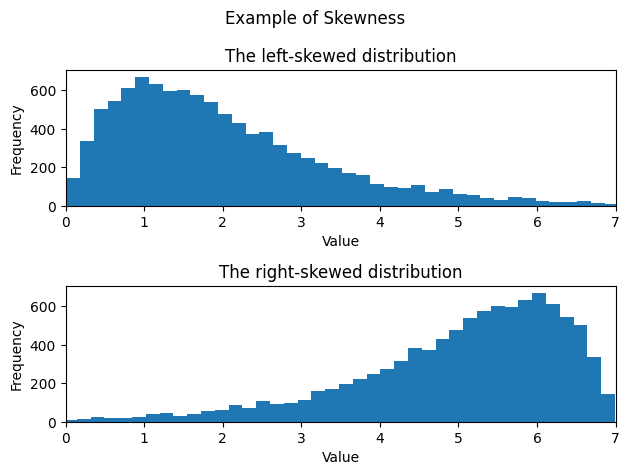

Skewness of left-skewed distribution is:  1.4084606095042138
Skewness of right-skewed distribution is:  -1.4084606095042145


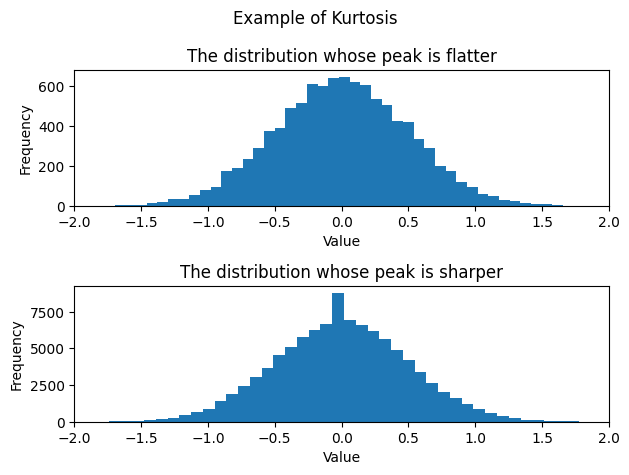

Kurtosis of distribution with flatter peak:  0.007001161881818874
Kurtosis of distribution with sharper peak:  0.06455642013719931


In [45]:
from scipy.stats import kurtosis, skew
import numpy as np
import matplotlib.pyplot as plt

array1 = np.random.gamma(shape=2, scale=1, size=10000)  # Generate a left-skewed distribution
array2 = 1-array1  # Generate a right-skewned distribution
array3 = np.random.normal(loc=0, scale=0.5, size=10000) # Generate a distribution whose peak is flat
array4 = np.random.normal(loc=0, scale=0.5, size=98000) # Generate a distribution whose peak is sharp
array4 = np.append(array4,np.zeros(2000))

fig, axis = plt.subplots(2,1)
fig.suptitle("Example of Skewness")
axis[0].hist(array1, bins=70)
axis[0].set_title('The left-skewed distribution')
axis[0].set_xlabel('Value')
axis[0].set_ylabel('Frequency')
axis[0].set_xlim(0,7)
axis[1].hist(7-array1, bins=70)
axis[1].set_title('The right-skewed distribution')
axis[1].set_xlabel('Value')
axis[1].set_ylabel('Frequency')
axis[1].set_xlim(0,7)
plt.tight_layout()
plt.show()

print("Skewness of left-skewed distribution is: ", skew(array1))
print("Skewness of right-skewed distribution is: ", skew(array2))


fig, axis = plt.subplots(2,1)
fig.suptitle("Example of Kurtosis")
axis[0].hist(array3, bins=50)
axis[0].set_title('The distribution whose peak is flatter')
axis[0].set_xlabel('Value')
axis[0].set_ylabel('Frequency')
axis[0].set_xlim(-2,2)
axis[1].hist(array4, bins=50)
axis[1].set_title('The distribution whose peak is sharper')
axis[1].set_xlabel('Value')
axis[1].set_ylabel('Frequency')
axis[1].set_xlim(-2,2)
plt.tight_layout()
plt.show()

print("Kurtosis of distribution with flatter peak: ", kurtosis(array3))
print("Kurtosis of distribution with sharper peak: ", kurtosis(array4))

# Frequency Domain

## Fast Fourier Transform (FFT)

A fast algorithm to calculate the DFT

$$
X[k] = \sum_{n=0}^{N-1}x[n]e^{-j2\pi kn/N}
$$
$$
x[n] = \frac{1}{2\pi}\sum_{k=0}^{N-1}X[k]e^{j2\pi kn/N}
$$
where $X$ denotes the result of FFT which is the spectrum, $x$ denotes the time-domain signal and $j$ is the imaginary unit.

$my\_fft$ gets the original signal and the sampling rate as input and outputs the frequency and corresponding mag which is a complex number. The length of the frequency is the half of the fs.

$my\_ifft$ gets the mag of the $my\_fft$ as input and outputs the original signal.

The basic function of the fft is orthogonal. Why orthogonal is important? Because it can help us determine the cofficient conveniently. We can only multiple the signal and the basic function to get the cofficient of the basic funtion.

Help on function my_fft in module dsp:

my_fft(signal, fs)
    Description:
        Get the spectrum of the input signal
    Args:
        signal: input signal
        fs: sampling rate
    Returns:
        The spectrum of the input, containing the freq of x-axis and the mag of the y-axis. The mag is complex number.

Help on function my_ifft in module dsp:

my_ifft(mag)
    Description:
        Use the mag of my_fft to recover the original signal
    Args:
        mag: Output of my_fft
    Returns:
        The recovered original signal. It is complex-valued.


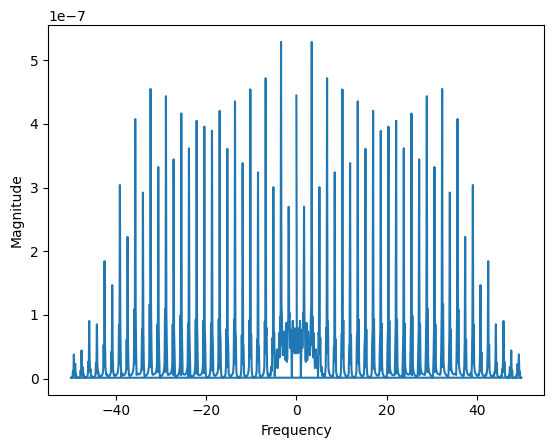

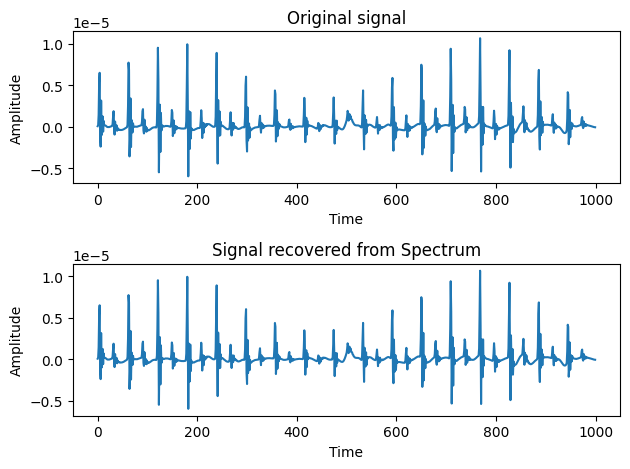

In [62]:
import numpy as np
from matplotlib import pyplot as plt
from dsp import my_fft, my_ifft

help(my_fft)
help(my_ifft)

signal = np.load("./data/sim_100_0.1_90_140_train.npy")[1,:1000]
fs = 100

freq, mag = my_fft(signal, fs)
plt.plot(freq, np.abs(mag))
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.show()

signal_recovered = my_ifft(mag)

fig, axis = plt.subplots(2,1)
axis[0].set_title("Original signal")
axis[0].set_xlabel("Time")
axis[0].set_ylabel("Amplitude")
axis[0].plot(signal)

axis[1].set_title("Signal recovered from Spectrum")
axis[1].plot(signal_recovered.real)
axis[1].set_xlabel("Time")
axis[1].set_ylabel("Amplitude")
plt.tight_layout()
plt.show()

## Frequency Domain Feature

### Power Spectral Density (PSD)
It is a tool used for frequency spectrum analysis to describe how the power of a signal varies with frequency.

The PSD represents the distribution of power across different frequencies in a signal, typically measured in power per Hertz (Hz). It can be computed by taking the squared magnitude of the Fourier transform of the signal. Specifically, for a time-domain signal x(t), the Power Spectral Density $S_{xx}(f)$ at frequency $f$ is calculated as:
$$
S_{xx}(f) = \lim_{{T \to \infty}} \frac{1}{T} \left| \int_{-T/2}^{T/2} x(t) e^{-j 2 \pi f t} \,dt \right|^2 
$$
where $x$ denotes the time-domain signal and $j$ denotes the imaginary unit.

Help on function psd in module dsp:

psd(signal, fs)
    Description:
        Extract the power spectral density (PSD) of a signal.
    Params:
        signal (numpy.ndarray): Input signal.
        fs (float): Sampling frequency of the signal.
    Returns:
        numpy.ndarray: Frequency vector.
        numpy.ndarray: Power spectral density values.


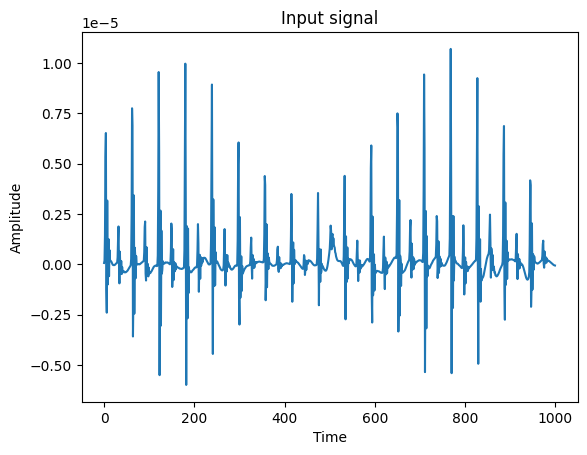

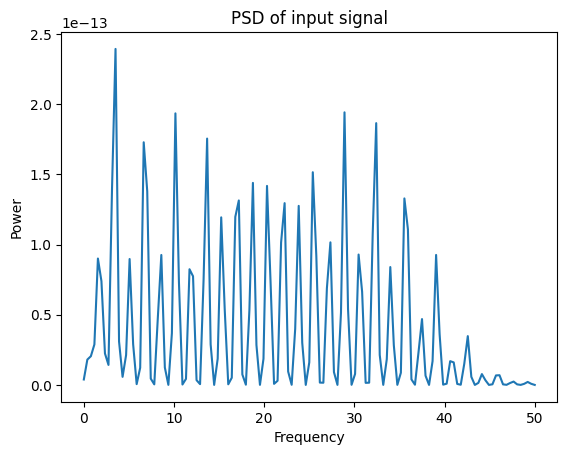

In [63]:
import numpy as np
from dsp import psd
import matplotlib.pyplot as plt

help(psd)

fs = 100
signal = np.load("./data/sim_100_0.1_90_140_train.npy")[1,:1000]
f,p = psd(signal, fs)

plt.title("Input signal")
plt.plot(signal)
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

plt.title("PSD of input signal")
plt.plot(f,p)
plt.xlabel("Frequency")
plt.ylabel("Power")
plt.show()

# Time-Frequency domain

## Short Time Fourier Transform (STFT)

To get the time information of the signal, we segment the signal and view the signal in the segment as stationary signal. However, when the signal does not complete an integer number of cycles, an issue known as Frequency Leakage may occur which can pose challenges in reconstructing the original signal based on the spectrum. To minimize the impact of Frequency Leakage, the original signal can be multiplied by a window function. After framing, we get many framed segment. Then we do the DFT to get frequency information of each frame. The scale of y axis is frequency. Then we concatenate the spectrum horizontally to get the spectrogram. The spectrogram has both the frequency and time frequency of a signal.

The longer the frame, the frequency information is more accurate, the time information is less accurate. The above is what we call heisenberg uncertainty principle.

The output of the stft is y-axis (frequency), x-axis (time) and the value of each point (magnitude). The max number of y-axis (frequency) is the half of the fs which is based on the Nyquist sampling princple, but the number of frequency in y-axis is the half of the nperseg. The number of the x-axis depends on the nperseg and the noverlap and the max number of the x-axis is (length of signal / fs). The output Z is complex-valued.

Help on function my_stft in module dsp:

my_stft(signal, fs, plot=False, window='hann', nperseg=256, noverlap=None, nfft=None, detrend=False, return_onesided=True, boundary='zeros', padded=True, axis=-1, scaling='spectrum')
    Description:
        Compute the Linear Spectrogram of a signal using Short-time Fourier Transform (STFT).
    
    Params:
        signal (numpy.ndarray): The input signal.
        fs (int): The sample rate of the signal.
        nperseg (int, optional): The size of the analysis window in samples. Default is 256.
        The other parameters are seldom used.
    
    Returns:
        freqs (numpy.ndarray): The frequency values in Hz.
        times (numpy.ndarray): The time values in seconds.
        spectrogram (numpy.ndarray): The computed linear spectrogram.


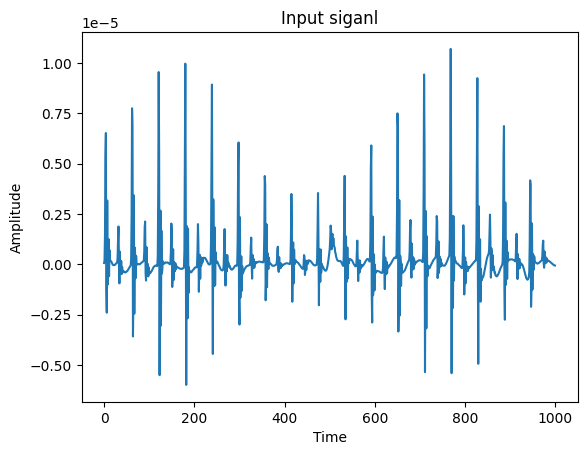

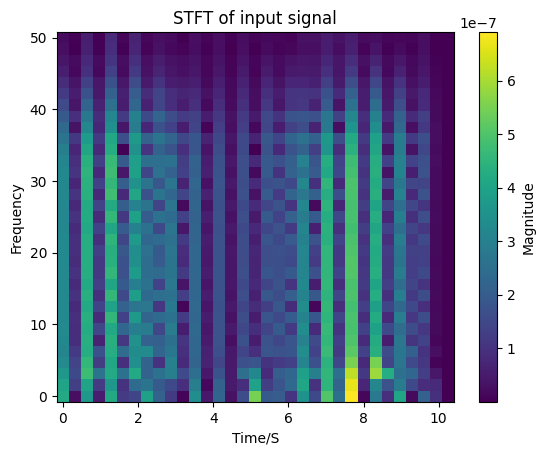

In [1]:
import numpy as np
from dsp import my_stft
import matplotlib.pyplot as plt

help(my_stft)

signal = np.load("./data/sim_100_0.1_90_140_train.npy")[1,:1000]


plt.title("Input siganl")
plt.plot(signal)
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

fs = 100 # sampling frequency
window = 'hann' # window type
nperseg = 64 # length of frame

# STFT
f, t, Z = my_stft(signal, plot=True, fs=fs, window=window, nperseg=nperseg)

## Wavelet Analysis

STFT has a serious problem, that is we can't get a good time and frequency resolution. The bigger the nperseg, the better the frequency resolution, but the worse time resolution, vice versa. The above problem is caused by the fact that the nperseg is fixed. So we introduce the wavelet analysis which is a MRA method. MRA (multiresolution analysis) is designed to give good time resolution and poor frequency resolution at high frequencies and good frequency resolution and poor time resolution at low frequencies.Generally, the basic function of wavelet transform is orthogonal and normalized (normalized makes the transformed signal have the same energy at every scale).

### Mexican Hat Wavelet

It is the second derivative of the Gaussian function.

Gaussian function:
$$
w(t) = \frac{1}{\sqrt{2\pi} \cdot \sigma} e^{\frac{-t^2}{2 \sigma^2}}
$$
where $\sigma$ is the standard deviation and $t$ is time. 

Second derivative of the Gaussian function:
$$
\psi(t) = \frac{1}{\sqrt{2 \pi} \cdot \sigma^3} \left( e^{\frac{-t^2}{2 \sigma^2}} \cdot \left( \frac{t^2}{\sigma^2} - 1 \right) \right)
$$

Help on function mexican_hat_wavelet in module dsp:

mexican_hat_wavelet(sigma, length)
    Description:
        Generate the mexican hat wavelet. It is the second derivative of the Gaussian function.
    Args:
        sigma: It has the same meaning in the Gaussian function
        length: length of the wavelet
    Returns:
        The mexican hat wavelet


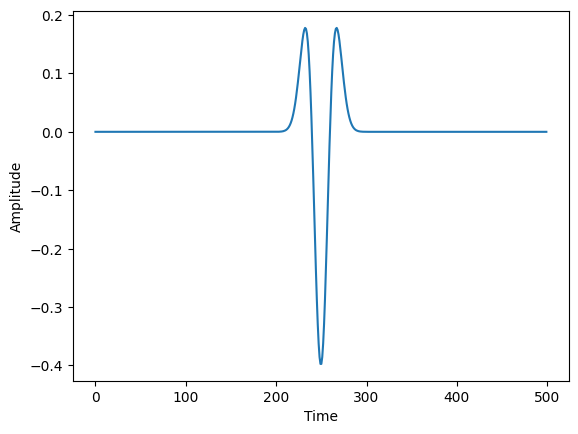

In [2]:
import matplotlib.pyplot as plt
from dsp import mexican_hat_wavelet

help(mexican_hat_wavelet)

sigma = 1
length = 50
psi = mexican_hat_wavelet(sigma, length)
plt.plot(psi)
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

### Morlet Wavelet 

It is defined as follows:
$$
w(t) = e^{i a t} \cdot e^{-\frac{t^2}{2\sigma}}
$$
where $t$ is the time variable, $a$ controls the frequency of the sinusoidal oscillation, and $\sigma$ controls the width of the Gaussian envelope.

Help on function morlet_wavelet in module dsp:

morlet_wavelet(length, sigma, a=5)
    Description:
        Generate the morlet wavelet which value is complex.
    Args:
        length: Length of the wavelet.
        sigma: Scaling parameter that affects the width of the window.
        a: Modulation parameter. Default is 5
    Returns:
        The morlet wavelet which is complex-valued.


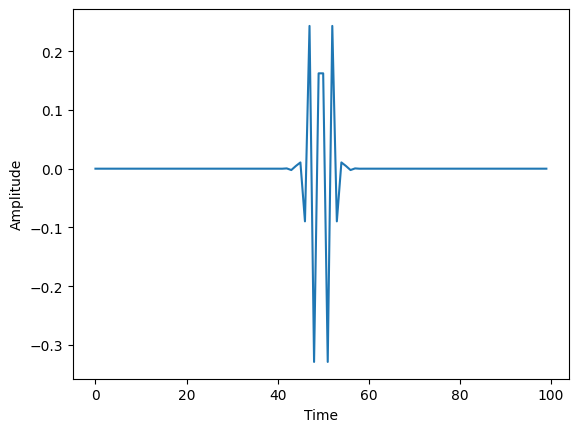

In [3]:
import matplotlib.pyplot as plt
from dsp import morlet_wavelet

help(morlet_wavelet)

length = 100
sigma = 2
a = 5
omega = morlet_wavelet(length, sigma, a)
plt.plot(omega.real)
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

### Continuous Wavelet Transform (CWT)

In CWT, the signal can be transformed by:

$$
CWT_x^\psi(\tau,s) = \Psi_x^\psi(\tau,s) = \frac{1}{\sqrt{|s|}} \int x(t) \psi^* \left( \frac{t - \tau}{s} \right) dt
$$

where the $\psi$ denotes the mother wavelet, $\tau$ denotes the translation of the wavelet, and $s$ denotes the sacle of the wavelet. $\tau$ and $s$ are all incremented continuously. However, if this transform needs to be computed by a computer, then both parameters are increased by a sufficiently small step size. This corresponds to sampling the time-scale plane.

### Inverse CWT

$$
x(t)=\frac{1}{c_{\psi}^{2}} \int_{s} \int_{\tau} \Psi_{x}^{\psi}(\tau, s) \frac{1}{s^{2}} \psi\left(\frac{t-\tau}{s}\right) d \tau d s
$$

where $c_{\psi}$ is a constant that depends on the wavelet used and the other symbols are described in above cell. $c_{\psi}$ can be calculated as follows:
$$
c_{\psi}=\left\{2 \pi \int_{-\infty}^{\infty} \frac{|\hat{\psi}(\xi)|^{2}}{|\xi|} d \xi\right\}^{1 / 2}
$$

where $\hat{\psi(\xi)}$ is the FT of $\psi(t)$

Help on function my_cwt in module dsp:

my_cwt(signal, scales, wavelet, fs, show=False)
    Description:
        Compute the cwt of the input signal
    Args:
        signal: input signal
        scales: the scales of wavelet, we can use pywt.scale2frequency to convert them to corresponding frequency
        wavelet: the type of the wavelet, there are "morl", "mexh" and so on. You can use
            wavlist = pywt.wavelist(kind='continuous') to get the available wavelet
        fs: the sampling frequency
        show: whether to show the result
    Returns:
        cofficient: the result of cwt. The length of y-axis depends on scales and length of x-axis depends on length of
            input signal
        frequencies: the corresponding frequencies to  scales


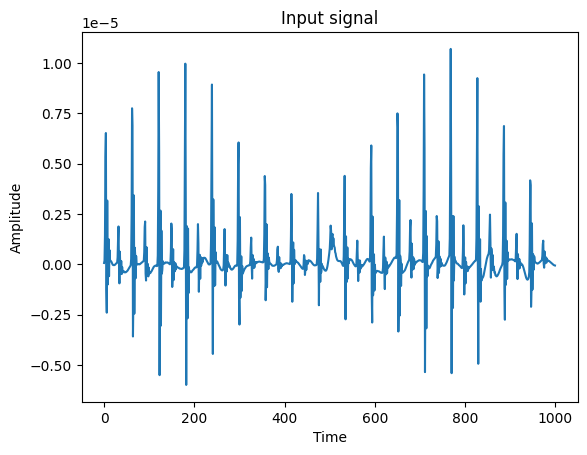

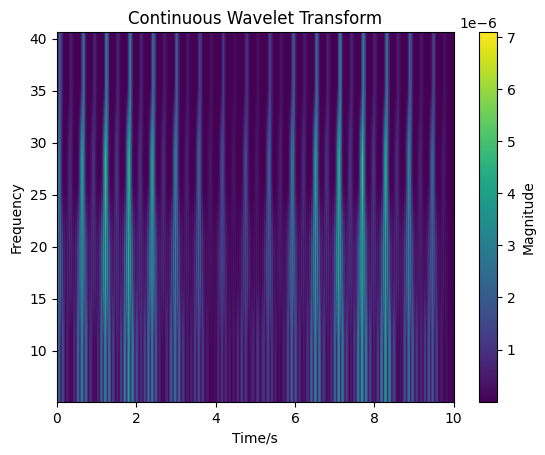

In [2]:
from dsp import my_cwt
import numpy as np
import matplotlib.pyplot as plt
    
help(my_cwt)
    
fs = 100
signal = np.load("./data/sim_100_0.1_90_140_train.npy")[1,:1000]
plt.title("Input signal")

plt.plot(signal)
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

scales = np.array([2,4,8,16])  
wavelet = 'morl' 

coefficients, frequencies = my_cwt(signal, scales, wavelet, fs, True)

## Polynomial Chirplet Transform (PCT)
PCT is a signal processing technique and a variant of the Chirplet Transform. The Chirplet Transform is a method used to analyze non-stationary modulations in signals, and PCT further introduces polynomial functions to enhance its analytical capabilities.

In the Chirplet Transform, "Chirp" refers to a signal with a frequency that varies over time, and a "Chirplet" is a wavelet associated with a Chirp. PCT introduces polynomial modulation functions, allowing the frequency, phase, and amplitude of Chirplets to vary according to the shape of the polynomial.

The core idea of PCT is to use polynomials to describe the nonlinear modulation characteristics of a signal, thereby better capturing the complex structures and non-stationary nature of the signal. This method is effective for analyzing signals where frequency, phase, and amplitude change over time.

### Chirplet Transform

The Chirplet Transform of a signal $x(t)$ is often represented as:
$$
C(a, b, \omega, \tau) = \int_{-\infty}^{\infty} x(t) \psi_{a, b, \omega, \tau}^*(t) \, dt
$$
where * denotes the complex conjugate and $\psi_{a, b, \omega, \tau}(t)$ is the Chirplet defined as:
$$
\psi_{a, b, \omega, \tau}(t) = e^{j(\omega t + \frac{a}{2}t^2 + b t + \tau)}
$$
### Polynomial Chirplet Transform

The Polynomial Chirplet Transform extends the Chirplet Transform by introducing a polynomial modulation. The general form is:
$$
C(a, b, \omega, \tau, P(t)) = \int_{-\infty}^{\infty} x(t) \psi_{a, b, \omega, \tau, P(t)}^*(t) \, dt
$$
Here, $P(t)$ is a polynomial function that modulates the Chirplet parameters.
$$
\psi_{a, b, \omega, \tau, P(t)}(t) = e^{j(\omega t + \frac{a}{2}t^2 + b t + \tau + P(t))} 
$$

Help on function chirplet_transform in module dsp:

chirplet_transform(signal, show=False)
    Description:
        Generate the chirplet_trainsform of the input signal
    Args:
        signal: Input signal
        show: whether to show the result of the chirplet transform
    Returns:
        The result of the chirplet transform


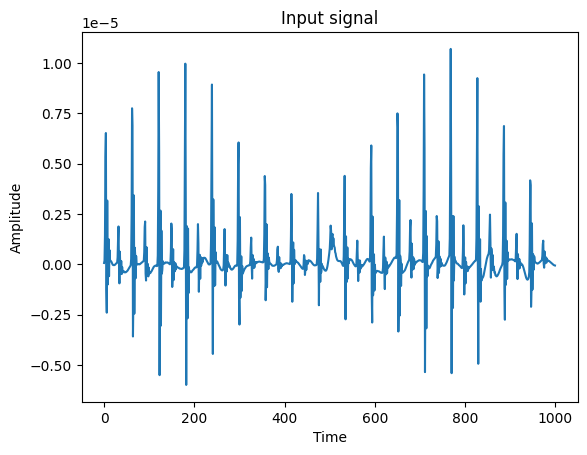

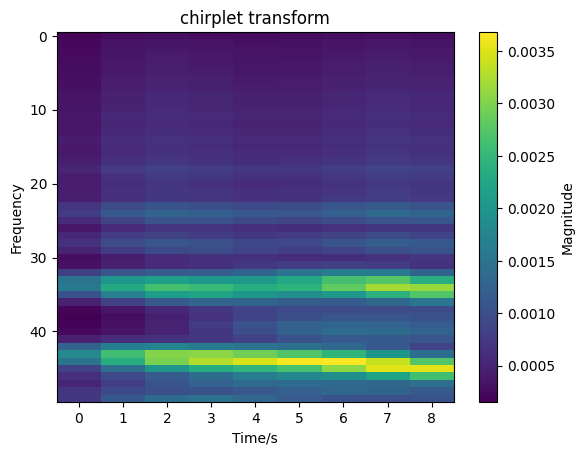

In [3]:
import numpy as np
from dsp import chirplet_transform
import matplotlib.pyplot as plt
    
help(chirplet_transform)
    
signal = np.load("./data/sim_100_0.1_90_140_train.npy")[1,:1000]
plt.title("Input signal")
plt.plot(signal)
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

ct_matrix = chirplet_transform(signal, show=True)

## Wigner Ville Distribution (WVD)


WVD is a time-frequency representation method widely used in signal processing and analysis. The primary goal of the Wigner-Ville Distribution is to provide a representation of the instantaneous frequency distribution of a signal. Unlike traditional methods such as Fourier transform and short-time Fourier transform, the Wigner-Ville Distribution offers more detailed information in both time and frequency domains, simultaneously depicting the variations of a signal over time and frequency.

The definition of WVD is as follows:
$$
W_x(t, f) = \int_{-\infty}^{\infty} x\left(t + \frac{\tau}{2}\right) \cdot \overline{x\left(t - \frac{\tau}{2}\right)} \cdot e^{-2\pi i f \tau} \,d\tau
$$
Here, $W_x(t, f)$ represents the WVD, $x(t)$ is the input signal, $\overline{x(t)}$ denotes the complex conjugate of $x(t)$, $t$ is time, and $f$ is frequency. The WVD describes the transient characteristics of a signal by computing the autocorrelation of the signal at different time windows.

The advantages of WVD include its adaptability to non-stationary signals and its ability to capture the transient features of a signal. However, WVD also has some drawbacks, such as the presence of cross terms that may introduce additional complexity to the analysis.

Help on function my_wvd in module dsp:

my_wvd(signal, show=False)
    Description:
        Analyze the time-frequency characteristics of a signal using the Wigner-Ville Transform (WVT) and visualize the results.
    
    Params:
        signal (numpy.ndarray): The input signal.
        show: whether to plot the result
    Returns:
        tfr_wvd (numpy.ndarray): The time-frequency representation (WVD) of the signal.
        t_wvd (numpy.ndarray): Time values corresponding to the WVD.
        f_wvd (numpy.ndarray): Normalized frequency values corresponding to the WVD.


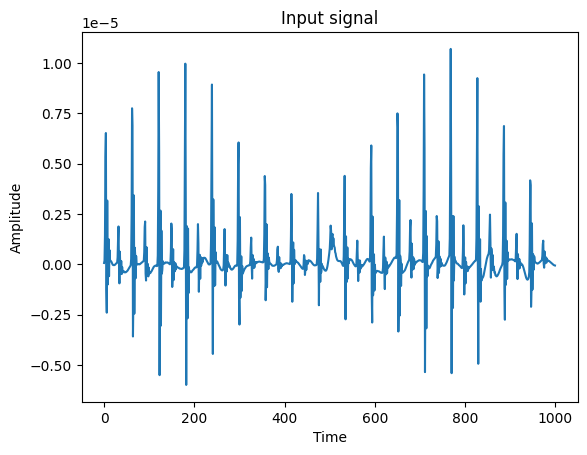

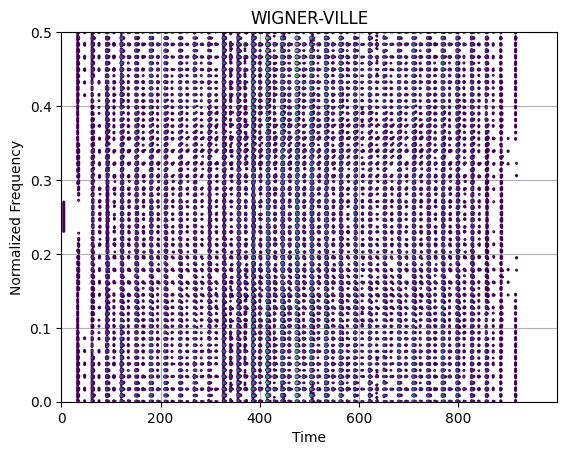

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from dsp import my_wvd

help(my_wvd)

signal = np.load("./data/sim_100_0.1_90_140_train.npy")[1,:1000]
plt.title("Input signal")
plt.plot(signal)
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

matrix, t, f = my_wvd(signal, show=True)

## SynchroSqueezing Transform (SST)

SST is a signal processing technique designed to analyze the time-frequency structure in non-stationary and non-linear signals. SST aims to enhance the resolution of signals in the time-frequency domain, particularly when dealing with non-linear and non-stationary conditions.


1. **Time-Frequency Localization:** SST seeks to capture the instantaneous frequency information of a signal by localizing it on the time-frequency plane. This allows for a more accurate analysis of the time and frequency characteristics of non-stationary signals.

2. **Reassignment Representation:** SST employs a technique known as reassignment representation, redistributing the signal on the time-frequency plane. This helps improve the resolution of local structures in the signal, making it easier to identify and analyze features in the time-frequency domain.

3. **Sync Reassignment:** The core idea of SST involves remapping the spectral information of the Fourier transform onto the time-frequency plane, obtaining a more refined and accurate time-frequency analysis of the signal. This sync reassessment allows for better detection of instantaneous frequency changes in the signal.


Help on function sst_stft in module dsp:

sst_stft(signal, fs, window, nperseg=256, show=False, n_fft=None, hop_len=1, modulated=True, ssq_freqs=None, padtype='reflect', squeezing='sum', gamma=None, preserve_transform=None, dtype=None, astensor=True, flipud=False, get_w=False, get_dWx=False)
    Description:
        Synchrosqueezed Short-Time Fourier Transform.
    Args:
        signal: the input signal
        fs: frequency of sampling
        window: type of the window
        nperseg: Length of each segment
        show: whether to show the result
        n_fft: length of fft
        The other parameters are seldom used.
    Returns:
        Tx: Synchrosqueezed STFT of `x`, of same shape as `Sx`.
        Sx: STFT of `x`
        ssq_freqs: Frequencies associated with rows of `Tx`.
        Sfs: Frequencies associated with rows of `Sx` (by default == `ssq_freqs`).


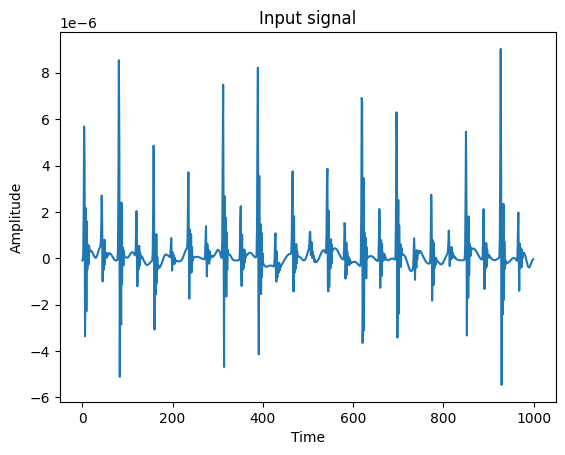

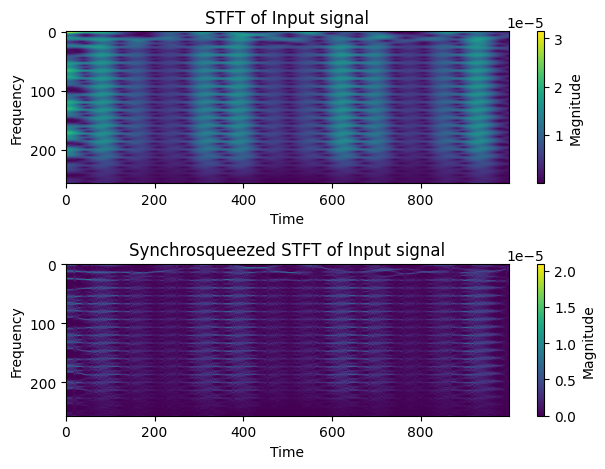

In [1]:
from dsp import sst_stft
import numpy as np
import matplotlib.pyplot as plt

help(sst_stft)

fs = 100
signal = np.load("./data/sim_100_0.1_90_140_train.npy")[2,:1000]
plt.title("Input signal")
plt.plot(signal)
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

Tx, Sx, ssq_freqs, Sfs= sst_stft(signal, window="ham", nperseg = 128, fs = fs, show=True)

Help on function sst_cwt in module dsp:

sst_cwt(signal, wavelet, scales, nv, fs, gamma=None, show=False)
    Description:
        Synchrosqueezed Continuous Wavelet Transform
    Args:
        signal: input of signal
        wavelet: the type of mother wavelet
        scales: how to scale the output, log or linear
        nv: number of voices
        fs: sampling frequency
        gamma: CWT phase threshold
        show: whether to show the result
    Returns:
        Tx: Synchrosqueezed CWT of `x`. (rows=~frequencies, cols=timeshifts)
            (nf = len(ssq_freqs); n = len(x))
            `nf = na` by default, where `na = len(scales)`.
        Wx: Continuous Wavelet Transform of `x`, L1-normed (see `cwt`).
        ssq_freqs: Frequencies associated with rows of `Tx`.
        scales: Scales associated with rows of `Wx`.


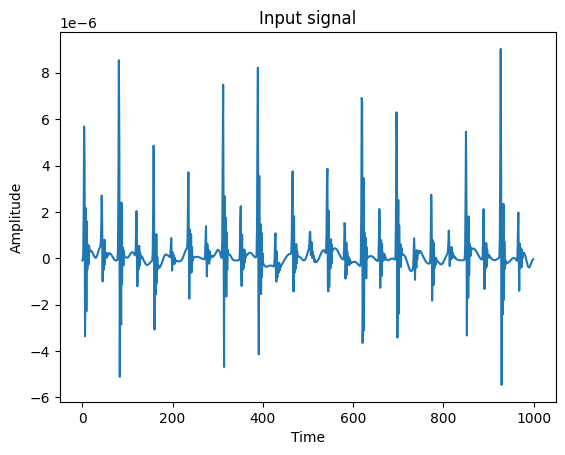

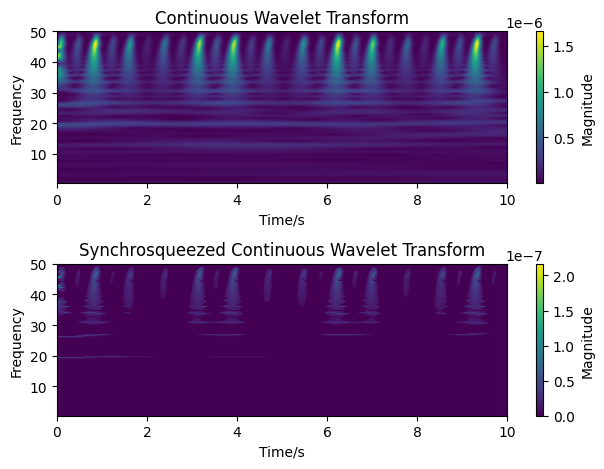

In [1]:
from dsp import sst_cwt
import numpy as np
import matplotlib.pyplot as plt

help(sst_cwt)

fs = 100
signal = np.load("./data/sim_100_0.1_90_140_train.npy")[2,:1000]
plt.title("Input signal")
plt.plot(signal)
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

Tx, Wx, ssq_freqs, scale= sst_cwt(signal, wavelet="morlet", scales="log", nv=20, fs = fs,gamma = 3e-7, show=True)